In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv('data/input/non_standardized_X_train.csv', index_col=0)
y_train = pd.read_csv('data/input/y_log_train.csv', index_col=0)

In [3]:
X_test = pd.read_csv('data/input/non_standardized_X_test.csv', index_col=0)

In [4]:
np.random.seed(42)

### 10-fold Cross-Validation

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [6]:
def kfold_mse(X, y, model, k=10):
    kf = KFold(n_splits=k)
    mses = []
    for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train['sales']) # Avoid deprecation warning
        y_pred = model.predict(X_val)
        mses.append(mean_squared_error(np.exp(y_pred), np.exp(y_val['sales'])))
    return mses

Gradient boosting have even more tunable parameters than random forest, therefore we shall concern only `learning_rate` and `max_depth` in this project. `n_estimators`, `max_features`, `min_samples_split` are fixed to 1000, 'sqrt' and 0.01. Since boosting is robust to overfitting, we can use as many estimators as computationally feasible.

In [7]:
learning_rates = [0.01, 0.1, 0.5, 1]
max_depths = [None, 3, 5, 10]

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

In [9]:
best_mses = []
best_avg_score = 1e9
best_lr = None
best_depth = None
for lr in learning_rates:
    for depth in max_depths:
        model = GradientBoostingRegressor(min_samples_split=0.01, n_estimators=1000, max_features='sqrt', random_state=42, learning_rate=lr, max_depth=depth)
        mses = kfold_mse(X_train, y_train, model)
        if np.mean(mses) < best_avg_score:
            best_avg_score = np.mean(mses)
            best_lr = lr
            best_depth = depth
            best_mses = mses
        print(f'lr: {lr}, max_depth: {depth}, avg_mse: {np.mean(mses)}')

lr: 0.01, max_depth: None, avg_mse: 323.1870080543094
lr: 0.01, max_depth: 3, avg_mse: 398.45692375512573
lr: 0.01, max_depth: 5, avg_mse: 331.7722639292242
lr: 0.01, max_depth: 10, avg_mse: 294.0796158180413
lr: 0.1, max_depth: None, avg_mse: 326.25985047000944
lr: 0.1, max_depth: 3, avg_mse: 264.9516844114877
lr: 0.1, max_depth: 5, avg_mse: 258.0014099419528
lr: 0.1, max_depth: 10, avg_mse: 282.1446829141696
lr: 0.5, max_depth: None, avg_mse: 354.4716400975657
lr: 0.5, max_depth: 3, avg_mse: 267.20948977282336
lr: 0.5, max_depth: 5, avg_mse: 306.35049744292354
lr: 0.5, max_depth: 10, avg_mse: 322.98594367040374
lr: 1, max_depth: None, avg_mse: 909.1653928409283
lr: 1, max_depth: 3, avg_mse: 2417.15684332923
lr: 1, max_depth: 5, avg_mse: 535.6104880559359
lr: 1, max_depth: 10, avg_mse: 837.6116750532854


### In-sample analysis

In [10]:
cv_df = pd.DataFrame(best_mses, columns=['Cross-Validation MSE'])
cv_df

,Cross-Validation MSE
0,134.808868
1,95.377476
2,338.965124
3,183.333613
4,240.468393
5,89.818731
6,385.104476
7,230.186855
8,794.723394
9,87.227171


In [11]:
cv_df.to_csv('data/output/cv/gbr_log.csv')

### Model fitting

After finding best parameters (not applicable to LR but useful for other models), we fit the model on the entire training set and predict on the test set. Also, we collect residuals to prepare for inventory decision making.

In [12]:
gbr = GradientBoostingRegressor(min_samples_split=0.01, n_estimators=1000, max_features='sqrt', random_state=42, learning_rate=best_lr, max_depth=best_depth)
gbr.fit(X_train, y_train['sales']) # Avoid deprecation warning
residuals = np.exp(y_train['sales']) - np.exp(gbr.predict(X_train))

In [13]:
output_df = X_test.copy()

In [14]:
output_df['sales'] = np.exp(gbr.predict(X_test))

### Inventory decision
As sales data come from a natural process, we shall not assume it is distributed in any particular model. Hence, we shall use an empirical distribution to make our inventory decision. 

In [15]:
residuals.describe()

count    2211.000000
mean        0.347791
std         2.692720
min        -8.505835
25%        -0.403451
50%         0.001758
75%         0.575518
max        57.085770
Name: sales, dtype: float64

For visualization of Empirical CDF, we use the `statsmodels` package:

In [16]:
from statsmodels.distributions.empirical_distribution import ECDF

In [17]:
ecdf = ECDF(residuals)

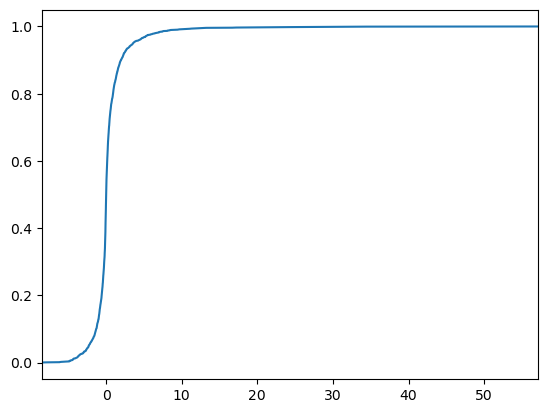

In [25]:
plt.plot(ecdf.x, ecdf.y)
plt.xlim(-8.5, 57.1)
plt.show()

Sparsity is not a concern since we have a large sample size. Therefore, we can use interpolation to obtain ppf. To get the empirical ppf, we can use scipy's `interp1d` to get the inverse function:

In [19]:
from scipy.interpolate import interp1d

In [20]:
eppf = interp1d(ecdf.y, ecdf.x)

Calculate the critical fractile

In [21]:
price = 20
cost = 12
salvage = 8
over = cost - salvage
under = price - cost
critical_fractile = under / (over + under)
critical_fractile

0.6666666666666666

We offset our predictions for the test datasets by the $eppf(critical\_fractile)$ to get the optimal inventory level.

In [22]:
output_df['inventory'] = eppf(critical_fractile) + output_df['sales']

In [23]:
output_df[['sales', 'inventory']].head()

,sales,inventory
0,29.396084,29.682996
1,74.648999,74.935910
2,10.295336,10.582247
3,24.091519,24.378430
4,8.907062,9.193973


In [24]:
output_df.to_csv('data/output/predictions/gbr_log.csv')